In [1]:
import numpy as np
import torch
import GPy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessClassifier
from visualize import *
from calibration import *
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
%matplotlib inline

NUM_BINS = 10
N = 2000 # takes value from 1 to 10000
NUM_CLASSES =  100
NUM_CLASSES_PLOT = 9
NUM_COL = 3
METHOD_NAME = "binary_gpc"

In [2]:
# Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
#       following by softmax of output logits of this image for each class.
data = np.genfromtxt("data/cifar100_predictions_dropout.txt")[0:N,:]# 10000*101

In [3]:
p = data[:,1:]
Y_predict = np.argmax(p, axis=1)
Y_true = data[:,0]

# Fit GPC to each class


Learned kernel: RBF(length_scale=0.189)

Learned kernel: RBF(length_scale=0.173)

Learned kernel: RBF(length_scale=0.05)

Learned kernel: RBF(length_scale=0.0673)

Learned kernel: RBF(length_scale=0.062)

Learned kernel: RBF(length_scale=0.05)

Learned kernel: RBF(length_scale=0.288)

Learned kernel: RBF(length_scale=0.05)

Learned kernel: RBF(length_scale=0.0507)

Learned kernel: RBF(length_scale=0.05) + 6.02**2 * RBF(length_scale=0.74)

Learned kernel: RBF(length_scale=0.05) + 7.15**2 * RBF(length_scale=0.89)

Learned kernel: RBF(length_scale=0.132) + 3.55**2 * RBF(length_scale=0.0137)

Learned kernel: RBF(length_scale=0.0551) + 4.98**2 * RBF(length_scale=1.02)

Learned kernel: RBF(length_scale=0.05) + 4.32**2 * RBF(length_scale=0.942)

Learned kernel: RBF(length_scale=0.05) + 6.58**2 * RBF(length_scale=0.936)

Learned kernel: RBF(length_scale=0.059) + 6.24**2 * RBF(length_scale=0.917)

Learned kernel: RBF(length_scale=0.05) + 7.92**2 * RBF(length_scale=1.14)

Learned kernel: RBF(le

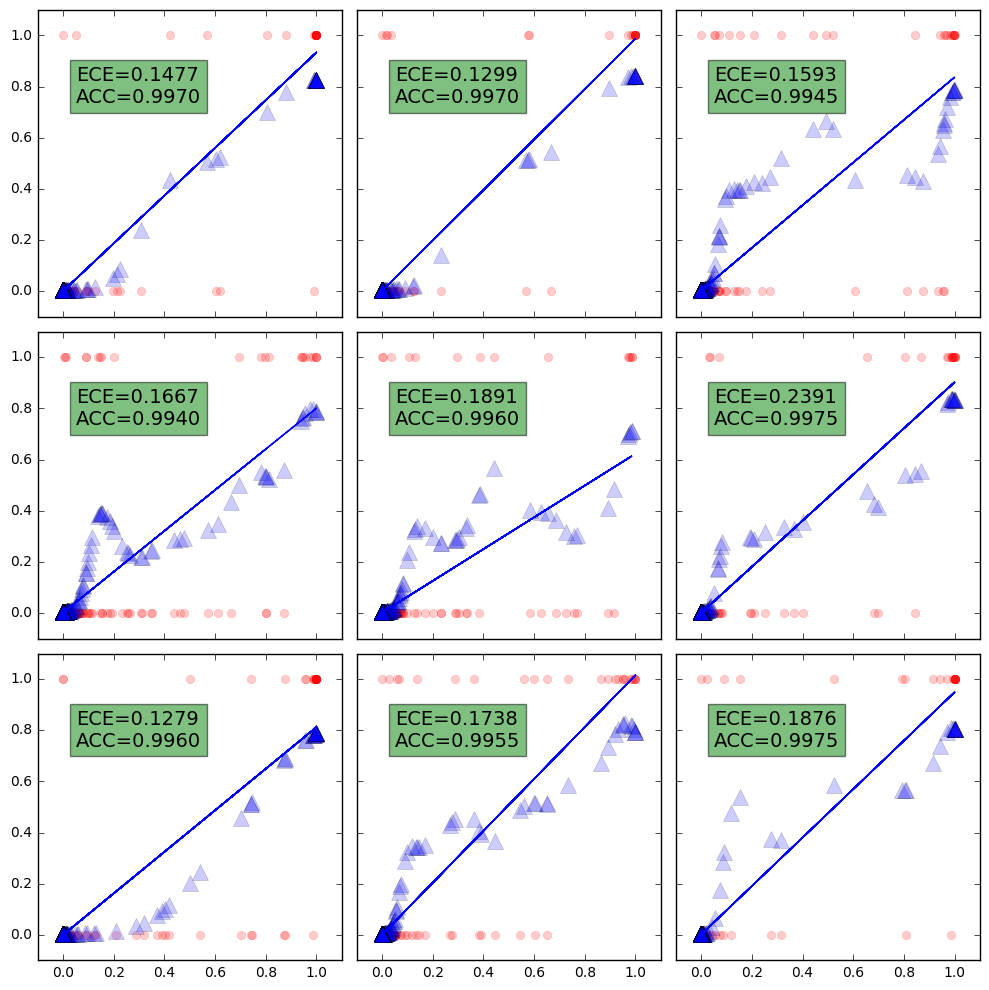

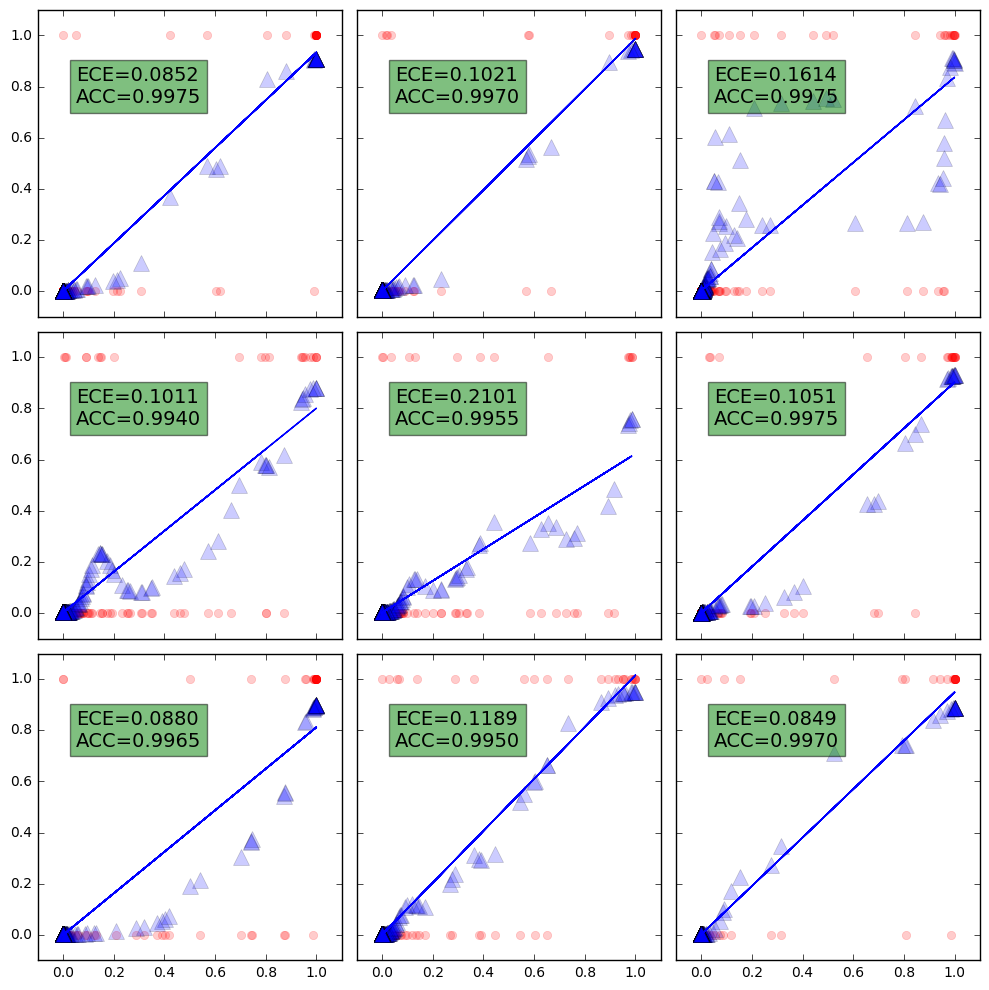

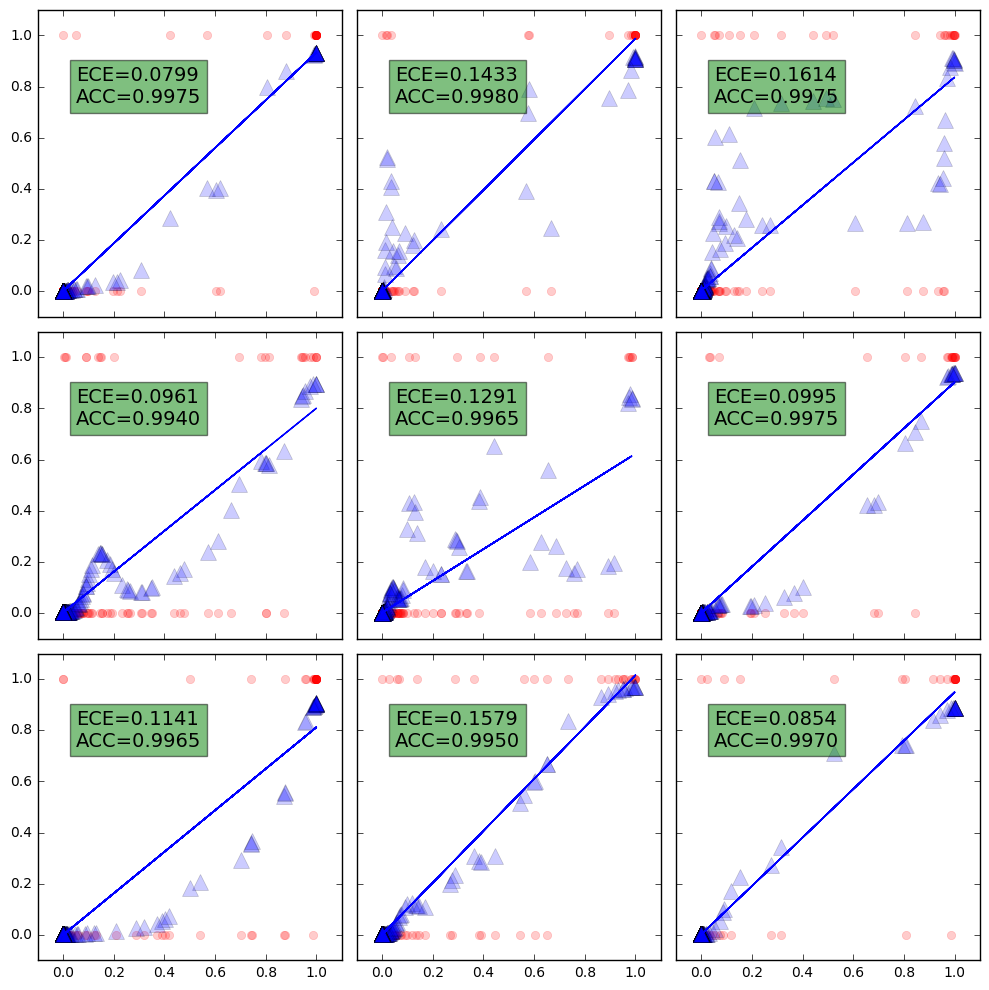

In [4]:
# GPC with sklearn
KERNELS = [RBF(0.1, (0.05, 1)), 
           RBF(0.1, (0.05, 1)) + 10**2 * RBF(1), 
           RBF(0.1, (0.05, 1)) + 10**2 * RBF(1) + 100.0 * DotProduct(sigma_0=1.0)]
for kernel in KERNELS:
    f, ax = plt.subplots(NUM_CLASSES_PLOT/NUM_COL, NUM_COL, sharex='col', sharey='row')
    f.set_figheight(10)
    f.set_figwidth(10)
    for K in range(NUM_CLASSES_PLOT):
        ax[K/NUM_COL, K%NUM_COL] = gpc_sklearn(ax[K/NUM_COL, K%NUM_COL],
                                                 p[:,K],
                                                 np.array((Y_true == K)) * 1,
                                                 kernel)
    f.tight_layout()
    #f.savefig("figures/%s/reliability_per_class.png" % METHOD_NAME)
    #f.savefig("figures/%s/reliability_per_class.eps" % METHOD_NAME, format='eps',dpi=1000)
    #plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')


Name : gp_classification
Objective : 38.431875842
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    1.0  |      +ve      |        
  rbf.lengthscale     |    1.0  |      +ve      |         

iteration: 0 
Name : gp_classification
Objective : 29.9802439325
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |   4.409910632170008  |      +ve      |        
  rbf.lengthscale     |  0.3121454280363374  |      +ve      |        


Name : gp_classification
Objective : 46.6653757751
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    1.0  |      +ve      |        
  rbf.lengthscale     |    1.0  |      +ve      |       

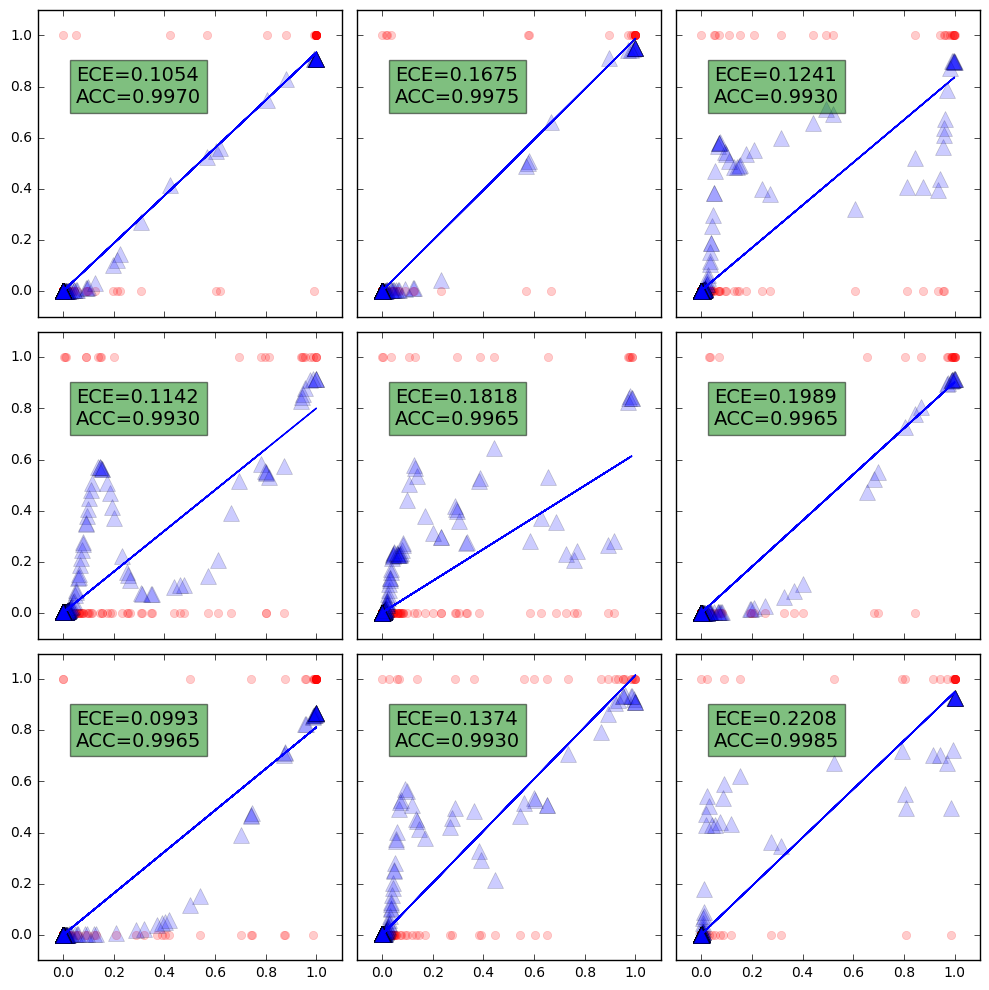

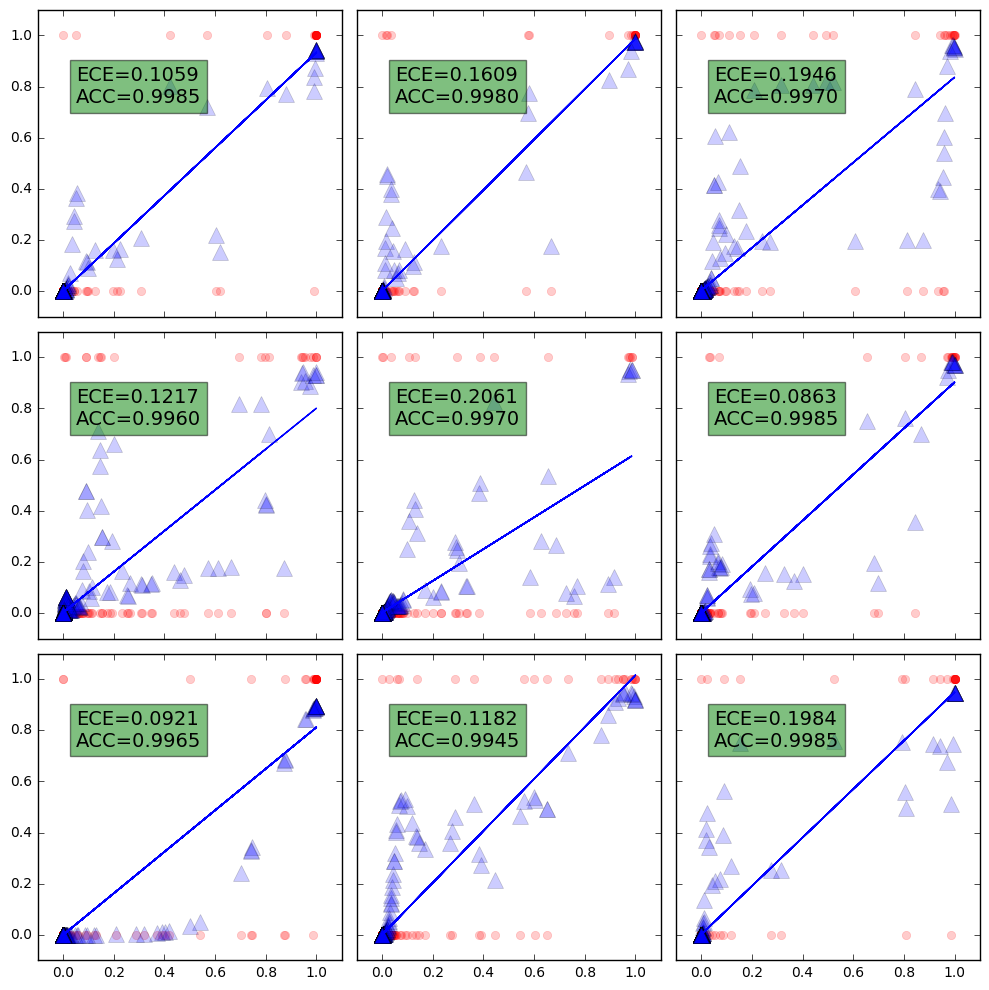

In [5]:
# GPC with GPy
KERNELS = [None, GPy.kern.RBF(1,variance=5.,lengthscale=0.1) + GPy.kern.Linear(1)]
for kernel in KERNELS:
    f, ax = plt.subplots(NUM_CLASSES_PLOT/NUM_COL, NUM_COL, sharex='col', sharey='row')
    f.set_figheight(10)
    f.set_figwidth(10)
    
    for K in range(NUM_CLASSES_PLOT):
        ax[K/NUM_COL, K%NUM_COL] = gpc_gpy(ax[K/NUM_COL, K%NUM_COL],
                                                 p[:,K],
                                                 np.array((Y_true == K)) * 1,
                                                 kernel)
    f.tight_layout()
    #f.savefig("figures/%s/reliability_per_class.png" % METHOD_NAME)
    #f.savefig("figures/%s/reliability_per_class.eps" % METHOD_NAME, format='eps',dpi=1000)
    #plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')